### 1D Burger's equation

$u_t + uu_{x} - (0.01/\pi)u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

**The aim is to solve the 1D Burger's equation**

In [3]:
import torch
import torch.nn as nn
from torch import autograd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
from copy import deepcopy

### Solve PDE with finite difference using py-pde 

In [2]:
import sys
sys.path.append('./py-pde/')

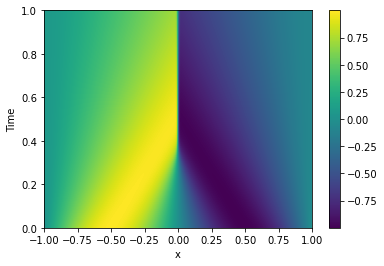

In [3]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc):
        super(Burger1D, self).__init__()
        self.bc = bc
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -u*u_x+(0.01/np.pi)*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")

storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0})
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [4]:
# reshape the output, create solution for evaluation of PINN's solution
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
fd_sol = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_t = torch.from_numpy(t_mesh.reshape(-1, 1)).float()
sol_x = torch.from_numpy(x_mesh.reshape(-1, 1)).float()

### Define a feedforward network and useful callbacks

In [9]:
class Dense(nn.Module):
    def __init__(self, activation, inputs, outputs):
        super(Dense, self).__init__()
        self.linear = nn.Linear(inputs, outputs)
        self.activation = activation
    
    def forward(self, x):
        return self.activation(self.linear(x))
    
    
class FFN(nn.Module):
    def __init__(self, activation, n_hidden, n_nodes):
        super(FFN, self).__init__()
        layers = []
        for i in range(n_hidden+2):
            if i == 0:
                layers.append(Dense(activation, 2, n_nodes))
            elif i == n_hidden+1:
                layers.append(nn.Linear(n_nodes, 1))
            else:
                layers.append(Dense(activation, n_nodes, n_nodes))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x, t):
        xt = torch.cat([x, t], axis=1)
        for l in self.layers:
            xt = l(xt)
        return xt
    

class Callback():
    def __init__(self): pass
    def on_train_begin(self): pass
    def on_train_end(self): pass
    def on_epoch_begin(self): pass
    def on_epoch_end(self): pass
    def on_batch_begin(self): pass
    def on_batch_end(self): pass
    def on_loss_begin(self): pass
    def on_loss_end(self): pass
    def on_step_begin(self): pass
    def on_step_end(self): pass
    

class ResamplingHandler(Callback):
    def __init__(self, trainer, sampling_rate):
        super(ResamplingHandler, self).__init__()
        self.sampling_rate = sampling_rate
        self.trainer = trainer
        
    def on_batch_begin(self, iteration, **kwargs):
        if iteration % self.sampling_rate == 0:
            self.trainer.generate_samples()
            
class ErrorTracker(Callback):
    def __init__(self, errors=[]):
        super(Tracker, self).super()
        self.errors = []
        
    def on_loss_end(self, loss, **kwargs):
        self.errors.append(loss)
        
class ValidationErrorTracker(Callback):
    def __init__(self, trainer, metric, validation, errors=[]):
        super(Tracker, self).super()
        self.errors = errors
        self.trainer = trainer
        self.metric = metric
        self.valid_x, self.valid_t, self.valid_u = validation
    def on_loss_end(self, **kwargs):
        return self.metric(self.trainer.net(valid_x, valid_t), valid_u)
            
    
class Burger1DNN:
    def __init__(self, N_init, N_bc, N_pde, net):
        self.net = net
        self.iteration = 0
        self.N_init, self.N_bc, self.N_pde = N_init, N_bc, N_pde
    
    @staticmethod
    def pde(x, t):
        u = self.net(x, t)
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        return u_t + u*u_x - (0.01/np.pi)*u_xx
    
    @staticmethod
    def initial_condtion(x, t):
        return self.net(x, t) + torch.sin(np.pi*x)
    
    @staticmethod
    def boundary_condition(x, t):
        return self.net(x, t)
    
    def generate_samples(self):
        self.x_init = (2.0*torch.rand((self.N_init, 1), requires_grad=True) - 1.0).to(device)
        self.t_init = (torch.zeros((self.N_init, 1), requires_grad=True)).to(device)

        self.t_bc = (torch.rand((self.N_bc, 1), requires_grad=True)).to(device)
        self.x_bc = (torch.ones((self.N_bc, 1))).to(device)
        self.x_bc[:int(n/2)] = -1
        self.x_bc.requires_grad = True

        self.x_pde = (2.0*torch.rand((self.N_pde, 1), requires_grad=True) - 1.0).to(device)
        self.t_pde = (torch.rand((self.N_pde, 1), requires_grad=True)).to(device)
    
    def train(self, optimizer, max_epochs, callbacks=[]):
        while self.iteration < max_epochs:
            for callback in callbacks:
                callback.on_batch_begin()
            optimizer.zero_grad()

            # loss from boundary and initial condition
            mse_u = mse_loss(self.initial_condtion(self.x_init, self.t_init), torch.zeros_like(self.t_init)) + \
            mse_loss(self.boundary_condition(self.x_bc, self.t_bc), torch.zeros_like(self.t_bc))

            # loss from PDE
            mse_f = mse_loss(self.pde(self.x_f0, self.t_f0), torch.zeros_like(self.t_f0))

            loss = mse_u + mse_f
            
            for callback in callbacks:
                callback.on_loss_end(**{'loss': loss})
            # BP gradient
            loss.backward(retain_graph=True)
            optimizer.step()
            self.iteration += 1
  

### Define pde

In [6]:
# defining the PDE residue
def f(net, x, t):
    u = net(x, t)
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    return u_t + u*u_x - (0.01/np.pi)*u_xx

In [7]:
# The true initial and boundary value.
def u_init(net, x, t):
    return net(x, t) + torch.sin(np.pi*x)
def u_bc(net, x, t):
    return net(x, t)

### Define loss function, optimizer and train

In [8]:
activation = torch.tanh
n_hidden = 5
n_nodes = 5

In [9]:
net_0 = FFN(activation, n_hidden, n_nodes)
initial_state = deepcopy(net_0.state_dict())
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net_0.parameters())

In [10]:
# Set number of samples
N_init = 50
N_bc = 50
N_f = 5000
max_epochs = 10000

In [11]:
# Create samples from initial condition
x_init = (2.0*torch.rand((N_init, 1), requires_grad=True) - 1.0).to(device)
t_init = (torch.zeros((N_init, 1), requires_grad=True)).to(device)

# Create samples from boundary condition
t_bc = (torch.rand((N_bc, 1), requires_grad=True)).to(device)
x_bc = (torch.ones((N_bc, 1))).to(device)
x_bc[:int(N_bc/2)] = -1
x_bc.requires_grad = True

# Create data point for pde constraint
x_f0 = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
t_f0 = (torch.rand((N_f, 1), requires_grad=True)).to(device)

errors_0 = []
losses_0 = []
for epoch in range(max_epochs):
    optimizer.zero_grad()
     
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net_0, x_init, t_init), torch.zeros_like(t_init)) + \
    mse_loss(u_bc(net_0, x_bc, t_bc), torch.zeros_like(t_bc))
    
    # loss from PDE
    mse_f = mse_loss(f(net_0, x_f0, t_f0), torch.zeros_like(t_f0))
    
    loss = mse_u + mse_f
    
    with autograd.no_grad():
        u = net_0(sol_x, sol_t)
        errors_0.append(mse_loss(u, fd_sol))
        losses_0.append(loss.item())
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 500 == 0:
        print('Epoch {}: loss is {}, error is {}'.format(epoch, loss, errors_0[-1]))

Epoch 0: loss is 0.4856047034263611, error is 0.44559797644615173
Epoch 500: loss is 0.2569633424282074, error is 0.1677316427230835
Epoch 1000: loss is 0.10786290466785431, error is 0.10596839338541031
Epoch 1500: loss is 0.0861746072769165, error is 0.09778263419866562
Epoch 2000: loss is 0.05959085747599602, error is 0.07026036828756332
Epoch 2500: loss is 0.027492884546518326, error is 0.04153616726398468
Epoch 3000: loss is 0.017978020012378693, error is 0.03743256255984306
Epoch 3500: loss is 0.013871558010578156, error is 0.036014020442962646
Epoch 4000: loss is 0.011239442974328995, error is 0.03486257418990135
Epoch 4500: loss is 0.009373527020215988, error is 0.03387007862329483
Epoch 5000: loss is 0.00817694142460823, error is 0.03149343281984329
Epoch 5500: loss is 0.007166548632085323, error is 0.02916921302676201
Epoch 6000: loss is 0.006562015973031521, error is 0.028999216854572296
Epoch 6500: loss is 0.00604646373540163, error is 0.028781061992049217
Epoch 7000: loss i

### Resample data point for pde at every ? epoch

In [12]:
net_1 = FFN(activation=torch.tanh, n_hidden=5, n_nodes=5)
net_1.load_state_dict(initial_state)
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net_1.parameters())

In [13]:
errors_1 = []
losses_1 = []
x_f, t_f = x_f0.clone(), t_f0.clone()
for epoch in range(max_epochs):
    optimizer.zero_grad()
    
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net_1, x_init, t_init), torch.zeros_like(t_init)) + \
    mse_loss(u_bc(net_1, x_bc, t_bc), torch.zeros_like(t_bc))
    
    # loss from PDE
    mse_f = mse_loss(f(net_1, x_f, t_f), torch.zeros_like(t_f))
    loss = mse_u + mse_f
    
    with autograd.no_grad():
        u = net_1(sol_x, sol_t)
        errors_1.append(mse_loss(u, fd_sol))
        losses_1.append(loss.item())
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Resample data point for pde constraint
    if (epoch+1) % 20 == 0:
        x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
        t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)
    
    if epoch % 500 == 0:
        print('Epoch {}: loss is {}, error is {}'.format(epoch, loss, errors_1[-1]))

Epoch 0: loss is 0.4856047034263611, error is 0.44559797644615173
Epoch 500: loss is 0.2578572928905487, error is 0.16845865547657013
Epoch 1000: loss is 0.11034200340509415, error is 0.10543900728225708
Epoch 1500: loss is 0.0957183837890625, error is 0.08788643032312393
Epoch 2000: loss is 0.08295151591300964, error is 0.08639896661043167
Epoch 2500: loss is 0.05048558861017227, error is 0.07557564973831177
Epoch 3000: loss is 0.04010416567325592, error is 0.03594895824790001
Epoch 3500: loss is 0.03127178177237511, error is 0.04738945886492729
Epoch 4000: loss is 0.026259269565343857, error is 0.02418610081076622
Epoch 4500: loss is 0.023035414516925812, error is 0.03187745064496994
Epoch 5000: loss is 0.019514229148626328, error is 0.020806020125746727
Epoch 5500: loss is 0.017098184674978256, error is 0.016766192391514778
Epoch 6000: loss is 0.014764193445444107, error is 0.02071763388812542
Epoch 6500: loss is 0.014872683212161064, error is 0.023893937468528748
Epoch 7000: loss i

**Resampling the date points at each epoch helps to avoid over-fitting of the PDE**

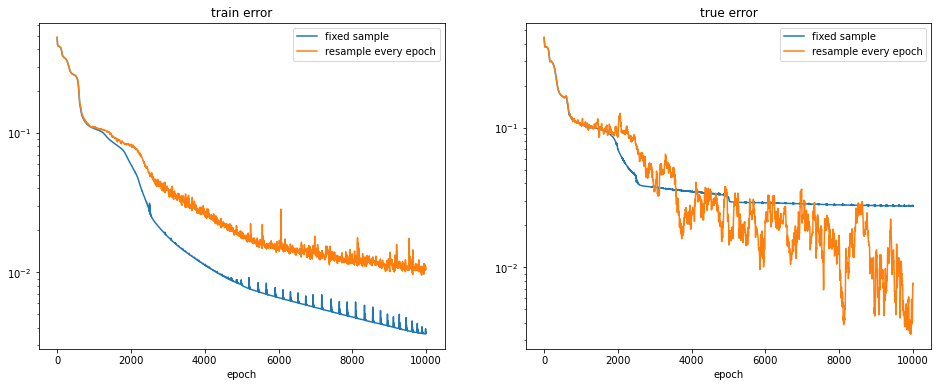

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
ax1.plot(losses_0)
ax1.plot(losses_1)
ax2.plot(errors_0)
ax2.plot(errors_1)
ax1.set_title('train error')
ax2.set_title('true error')
for ax in [ax1, ax2]:
    ax.legend(['fixed sample', 'resample every epoch'])
    ax.set_xlabel('epoch')
    ax.set_yscale('log')

### Testing with enforced boundary condition with $(x^2-1)$

In [15]:
class GalerkinFFN(FFN):
    def __init__(self, activation, n_hidden, n_nodes):
        super(GalerkinFFN, self).__init__(activation, n_hidden, n_nodes)
    
    def forward(self, x, t):
        xt = super(GalerkinFFN, self).forward(x, t)
        return (x**2 -1.0) * xt

In [16]:
net_2 = GalerkinFFN(activation=torch.tanh, n_hidden=5, n_nodes=5)
net_2.load_state_dict(initial_state)
optimizer = torch.optim.Adam(net_2.parameters())

In [17]:
errors_2 = []
losses_2 = []
for epoch in range(max_epochs):
    optimizer.zero_grad()
    
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net_2, x_init, t_init), torch.zeros_like(t_init))
    
    # loss from PDE
    mse_f = mse_loss(f(net_2, x_f0, t_f0), torch.zeros_like(t_f0))
    loss = mse_u + mse_f
    
    with autograd.no_grad():
        u = net_2(sol_x, sol_t)
        errors_2.append(mse_loss(u, fd_sol))
        losses_2.append(loss.item())
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Resample data point for pde constraint
    if (epoch+1) % 20 == 0:
        x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
        t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)
    
    if epoch % 500 == 0:
        print('Epoch {}: loss is {}, error is {}'.format(epoch, loss, errors_2[-1]))

Epoch 0: loss is 0.5569978356361389, error is 0.4136612117290497
Epoch 500: loss is 0.15596342086791992, error is 0.14990918338298798
Epoch 1000: loss is 0.12289901077747345, error is 0.13394097983837128
Epoch 1500: loss is 0.09507093578577042, error is 0.10172945261001587
Epoch 2000: loss is 0.057749275118112564, error is 0.07600349932909012
Epoch 2500: loss is 0.02600100077688694, error is 0.052125561982393265
Epoch 3000: loss is 0.021354492753744125, error is 0.048577405512332916
Epoch 3500: loss is 0.01702643744647503, error is 0.0455457866191864
Epoch 4000: loss is 0.013352087698876858, error is 0.043400537222623825
Epoch 4500: loss is 0.010830838233232498, error is 0.04153719171881676
Epoch 5000: loss is 0.008971894159913063, error is 0.040510598570108414
Epoch 5500: loss is 0.007796915248036385, error is 0.039272844791412354
Epoch 6000: loss is 0.006968488916754723, error is 0.03416062891483307
Epoch 6500: loss is 0.006382699124515057, error is 0.033244721591472626
Epoch 7000: l

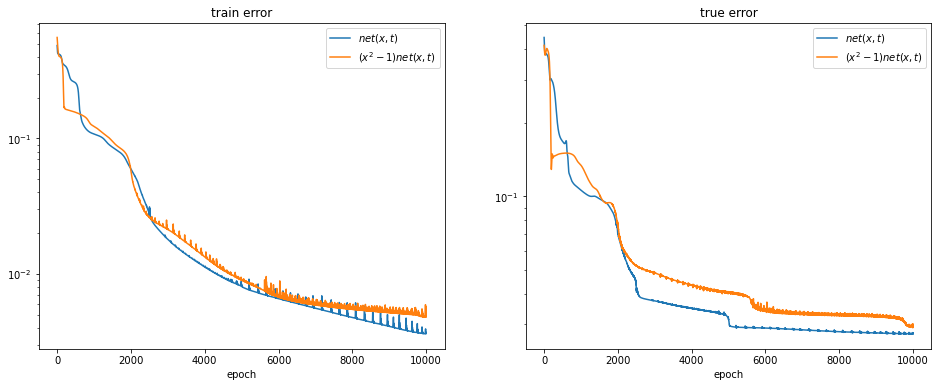

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
ax1.plot(losses_0)
ax1.plot(losses_2)
ax2.plot(errors_0)
ax2.plot(errors_2)
ax1.set_title('train error')
ax2.set_title('true error')
for ax in [ax1, ax2]:
    ax.legend([r'$net(x, t)$', r'$(x^2-1)net(x, t)$'])
    ax.set_xlabel('epoch')
    ax.set_yscale('log')